## Predicting survival after thoracic surgery using:
### - a simple random forest classifier 
### - a simple dense deep learning model


In [1]:
import platform
print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print('Platform System: ' + platform.system())
print(platform.processor())
print(platform.python_compiler())

x86_64
Darwin Kernel Version 18.6.0: Thu Apr 25 23:16:27 PDT 2019; root:xnu-4903.261.4~2/RELEASE_X86_64
Darwin-18.6.0-x86_64-i386-64bit
uname_result(system='Darwin', node='Tommy-1520.local', release='18.6.0', version='Darwin Kernel Version 18.6.0: Thu Apr 25 23:16:27 PDT 2019; root:xnu-4903.261.4~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Platform System: Darwin
i386
GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)


### Versions used in this notebook

In [2]:
import sys
import numpy
import matplotlib
import pandas
import keras

print('Python: {}'.format(sys.version))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy: 1.15.4
matplotlib: 3.0.2
pandas: 0.23.4
keras: 2.2.4


In [3]:
# data handling
import pandas as pd 

# matrix operations  
import numpy as np 

# plotting
import matplotlib.pyplot as plt

# data preprocessing and random forest model 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call

from keras.utils.np_utils import to_categorical

# over sampling
import imblearn
from imblearn.over_sampling import SMOTE

# deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from IPython.display import Image



### Read in csv data 

In [4]:
names = ['diagnosis', 'fvc', 'fev1', 'performance_status', 'pain_before_surgery',
        'haemoptysis_before_surgery', 'dyspnoea_before_surgery', 'cough_before_surgery', 'weakness_before_surgery',
        'tumour_size', 'diabetes_mellitus', 'mi_6_months', 'peripheral_arterial_disease', 'smoking', 'asthma', 
         'age', 'survival']

df = pd.read_csv("thoracic-surgery-data copy.csv", names = names)

df = df.drop(columns=['diagnosis'])

df.head(10)

,fvc,fev1,performance_status,pain_before_surgery,haemoptysis_before_surgery,dyspnoea_before_surgery,cough_before_surgery,weakness_before_surgery,tumour_size,diabetes_mellitus,mi_6_months,peripheral_arterial_disease,smoking,asthma,age,survival
0,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
1,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
2,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
4,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T
5,2.48,1.88,PRZ1,F,F,F,T,F,OC11,F,F,F,F,F,51,F
6,4.36,3.28,PRZ1,F,F,F,T,F,OC12,T,F,F,T,F,59,T
7,3.19,2.50,PRZ1,F,F,F,T,F,OC11,F,F,T,T,F,66,T
8,3.16,2.64,PRZ2,F,F,F,T,T,OC11,F,F,F,T,F,68,F
9,2.32,2.16,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,54,F


In [5]:
df.rename(
    columns = {'survival': 'class'},
    inplace = True) 

df.head(1)

,fvc,fev1,performance_status,pain_before_surgery,haemoptysis_before_surgery,dyspnoea_before_surgery,cough_before_surgery,weakness_before_surgery,tumour_size,diabetes_mellitus,mi_6_months,peripheral_arterial_disease,smoking,asthma,age,class
0,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F


### One hot encode features with non-binary classes

In [6]:
one_hot = pd.get_dummies(df['performance_status'])
df = df.drop('performance_status',axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['tumour_size'])
df = df.drop('tumour_size',axis = 1)
df = df.join(one_hot)

In [7]:
pd.set_option('display.max_columns', None)
df.head(5)

,fvc,fev1,pain_before_surgery,haemoptysis_before_surgery,dyspnoea_before_surgery,cough_before_surgery,weakness_before_surgery,diabetes_mellitus,mi_6_months,peripheral_arterial_disease,smoking,asthma,age,class,PRZ0,PRZ1,PRZ2,OC11,OC12,OC13,OC14
0,2.88,2.16,F,F,F,T,T,F,F,F,T,F,60,F,0,1,0,0,0,0,1
1,3.40,1.88,F,F,F,F,F,F,F,F,T,F,51,F,1,0,0,0,1,0,0
2,2.76,2.08,F,F,F,T,F,F,F,F,T,F,59,F,0,1,0,1,0,0,0
3,3.68,3.04,F,F,F,F,F,F,F,F,F,F,54,F,1,0,0,1,0,0,0
4,2.44,0.96,F,T,F,T,T,F,F,F,T,F,73,T,0,0,1,1,0,0,0


### Categorical data to numerical data

In [8]:
df['pain_before_surgery'] = pd.get_dummies(df['pain_before_surgery'])
df['haemoptysis_before_surgery'] = pd.get_dummies(df['haemoptysis_before_surgery'])
df['dyspnoea_before_surgery'] = pd.get_dummies(df['dyspnoea_before_surgery'])
df['cough_before_surgery'] = pd.get_dummies(df['cough_before_surgery'])
df['weakness_before_surgery'] = pd.get_dummies(df['weakness_before_surgery'])
df['diabetes_mellitus'] = pd.get_dummies(df['diabetes_mellitus'])
df['mi_6_months'] = pd.get_dummies(df['mi_6_months'])
df['peripheral_arterial_disease'] = pd.get_dummies(df['peripheral_arterial_disease'])
df['smoking'] = pd.get_dummies(df['smoking'])
df['asthma'] = pd.get_dummies(df['asthma'])
df['class'] = pd.get_dummies(df['class'])

df.head(5)

,fvc,fev1,pain_before_surgery,haemoptysis_before_surgery,dyspnoea_before_surgery,cough_before_surgery,weakness_before_surgery,diabetes_mellitus,mi_6_months,peripheral_arterial_disease,smoking,asthma,age,class,PRZ0,PRZ1,PRZ2,OC11,OC12,OC13,OC14
0,2.88,2.16,1,1,1,0,0,1,1,1,0,1,60,1,0,1,0,0,0,0,1
1,3.40,1.88,1,1,1,1,1,1,1,1,0,1,51,1,1,0,0,0,1,0,0
2,2.76,2.08,1,1,1,0,1,1,1,1,0,1,59,1,0,1,0,1,0,0,0
3,3.68,3.04,1,1,1,1,1,1,1,1,1,1,54,1,1,0,0,1,0,0,0
4,2.44,0.96,1,0,1,0,0,1,1,1,0,1,73,0,0,0,1,1,0,0,0


### One class significantly outnumbers the other. We upsample using SMOTE as a workaround for this later in the notebook.

In [9]:
df.groupby('class').count()

,fvc,fev1,pain_before_surgery,haemoptysis_before_surgery,dyspnoea_before_surgery,cough_before_surgery,weakness_before_surgery,diabetes_mellitus,mi_6_months,peripheral_arterial_disease,smoking,asthma,age,PRZ0,PRZ1,PRZ2,OC11,OC12,OC13,OC14
class,,,,,,,,,,,,,,,,,,,,
0,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70
1,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400


### Run a quick random forest classifier for an accuracy baseline with minimal preprocessing

In [10]:
y = np.array(df['class'])
df = np.array(df.drop(['class'], 1))
X = np.array(df)

seed = 0

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = seed,
    shuffle = True)

Y_train = to_categorical(y_train,
                         num_classes = None)

Y_test = to_categorical(y_test,
                        num_classes = None)

In [11]:
clf = RandomForestClassifier(
    n_estimators = 100,
    random_state = 0)

clf = clf.fit(X_train,y_train)

preds = clf.predict(X_test)

pd.crosstab(
    y_test,
    preds,
    rownames = ['Actual'],
    colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1,17
1,0,76


### Quick random forest classifier gives an accuracy of 80%, we should expect deep learning to achieve this value as well.

In [12]:
total = len(preds)
correct = 0
for pred, actual in zip(preds,y_test):
    if pred == actual:
        correct += 1
        
print('Prediction accuracy: ' + str(correct/float(total)))
print('')

Prediction accuracy: 0.8191489361702128



In [13]:
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO() 
tree.export_graphviz(clf[0], out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

graph[0].write_pdf("tree.png") 

### Preprocess data (normalize and standard scale) for deep learning

In [14]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(df)
df = scaler.transform(df)

scaler = StandardScaler()
scaler.fit(df)
df = scaler.transform(df)

In [15]:
df

array([[-0.46140527, -0.20490295,  0.26573489, ..., -1.09844106,
        -0.20525253,  5.16207892],
       [ 0.13597486, -0.22872193,  0.26573489, ...,  0.91038111,
        -0.20525253, -0.1937204 ],
       [-0.59926222, -0.21170838,  0.26573489, ..., -1.09844106,
        -0.20525253, -0.1937204 ],
       ...,
       [-0.277596  , -0.21170838,  0.26573489, ..., -1.09844106,
         4.87204701, -0.1937204 ],
       [-1.51830858, -0.24573549,  0.26573489, ...,  0.91038111,
        -0.20525253, -0.1937204 ],
       [ 1.65240135, -0.08580805,  0.26573489, ...,  0.91038111,
        -0.20525253, -0.1937204 ]])

In [16]:
X = np.array(df)

### Split data into training, validation, and testing sets. Upsample to a 0.8 ratio using imblearn.

In [17]:
seed = 15

# split for train, test
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=0.3,
    random_state = seed,
    shuffle = True)

Y_train = to_categorical(y_train,
                         num_classes = None)

Y_test = to_categorical(y_test,
                        num_classes = None)

# split for train, validation
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(
    X_train,
    Y_train,
    test_size=0.3,
    random_state = seed,
    shuffle = True)

# Upsampling
sm = SMOTE(
    sampling_strategy='not majority',
    k_neighbors = 10,
    n_jobs = 1,
    random_state = 12,
    ratio = 0.7)

X_res, Y_res = sm.fit_sample(X_train, Y_train)


### Create a quick deep dense learning model with 
#### - Residual connections between each dense layer 
#### - Dropout between non-input and non-output layers to reduce overfitting

In [32]:
input_layer = Input(shape=(20,))

x = Dense(
    units = 64,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(input_layer)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

skip1 = x

x = Dense(
    units = 64,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip1])
x = Activation('relu')(x)

skip2 = x 

x = Dropout(rate = 0.3)(x)

x = Dense(
    units = 64,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip2])
x = Activation('relu')(x)

x = Dropout(rate = 0.3)(x)

x = Dense(
    units = 64,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(input_layer)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip1])
x = keras.layers.Add()([x, skip2])
x = Activation('relu')(x)

x = Dropout(rate = 0.3)(x)

y = Dense(
    units = 2,
    activation='softmax')(x)

model = Model(
    inputs = input_layer,
    outputs = y)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           1344        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 64)           256         dense_11[0][0]                   
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 64)           0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
dense_12 (

### Choose the optimizer, initialize the learning rate, add callbacks to monitor network learning

In [33]:
opt = SGD(lr= 2e-4)

model.compile(
    loss = "categorical_crossentropy",
    optimizer = opt,
    metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor=0.5,
    patience = 5, 
    min_lr = 5e-7,
    verbose = 1)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    restore_best_weights = True)

history = model.fit(
    X_train,
    Y_train,                   
    epochs = 300, 
    batch_size = 4,
    verbose = 1,
    validation_data = (X_val, Y_val),
    callbacks = [reduce_lr,
                early_stopping])

Train on 230 samples, validate on 99 samples
Epoch 1/300
230/230 [==============================] - 1s 5ms/step - loss: 1.1594 - acc: 0.4609 - val_loss: 1.0507 - val_acc: 0.4949
Epoch 2/300
230/230 [==============================] - 0s 555us/step - loss: 1.0093 - acc: 0.4696 - val_loss: 0.9694 - val_acc: 0.5051
Epoch 3/300
230/230 [==============================] - 0s 612us/step - loss: 0.9829 - acc: 0.4696 - val_loss: 0.9070 - val_acc: 0.4949
Epoch 4/300
230/230 [==============================] - 0s 583us/step - loss: 0.9219 - acc: 0.5522 - val_loss: 0.8435 - val_acc: 0.5253
Epoch 5/300
230/230 [==============================] - 0s 680us/step - loss: 0.9093 - acc: 0.5130 - val_loss: 0.8031 - val_acc: 0.5556
Epoch 6/300
230/230 [==============================] - 0s 679us/step - loss: 0.7990 - acc: 0.6000 - val_loss: 0.7532 - val_acc: 0.5556
Epoch 7/300
230/230 [==============================] - 0s 683us/step - loss: 0.8269 - acc: 0.5739 - val_loss: 0.7245 - val_acc: 0.5960
Epoch 8/300


230/230 [==============================] - 0s 1ms/step - loss: 0.4992 - acc: 0.7957 - val_loss: 0.4718 - val_acc: 0.8788
Epoch 62/300
230/230 [==============================] - 0s 521us/step - loss: 0.5109 - acc: 0.7957 - val_loss: 0.4719 - val_acc: 0.8788
Epoch 63/300
230/230 [==============================] - 0s 676us/step - loss: 0.4815 - acc: 0.8348 - val_loss: 0.4742 - val_acc: 0.8788
Epoch 64/300
230/230 [==============================] - 0s 600us/step - loss: 0.4881 - acc: 0.8174 - val_loss: 0.4717 - val_acc: 0.8788

Epoch 00064: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 65/300
230/230 [==============================] - 0s 546us/step - loss: 0.4936 - acc: 0.8000 - val_loss: 0.4725 - val_acc: 0.8889
Epoch 66/300
230/230 [==============================] - 0s 623us/step - loss: 0.5048 - acc: 0.8043 - val_loss: 0.4692 - val_acc: 0.8889
Epoch 67/300
230/230 [==============================] - 0s 606us/step - loss: 0.4127 - acc: 0.8217 - val_loss: 0.4681 

In [34]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

### Plot model/validation accuracy and model/validation loss per epoch (note dropout causes the validation accuracy and loss to appear better than the training).

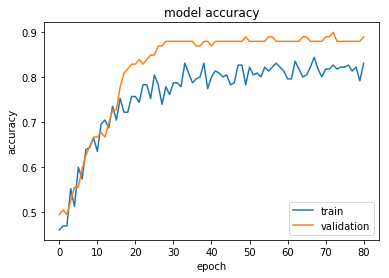

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

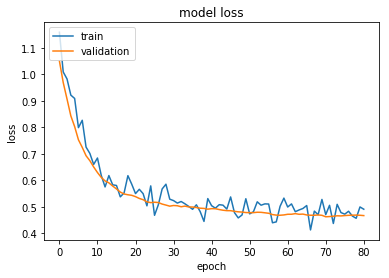

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Predict using the learned weights. We can see the model we created performed generally as well as the random forest classifier. 

In [37]:
predictions = model.predict(X_test)
print('Test accuracy: ' + str(accuracy_score(np.argmax(Y_test, axis=1),np.argmax(predictions, axis=1))))
print('')
print('')
print(classification_report(np.argmax(Y_test, axis=1),np.argmax(predictions, axis=1)))

Test accuracy: 0.8297872340425532


              precision    recall  f1-score   support

           0       0.50      0.08      0.14        24
           1       0.84      0.98      0.91       117

   micro avg       0.83      0.83      0.83       141
   macro avg       0.67      0.53      0.52       141
weighted avg       0.78      0.83      0.78       141



In [38]:
del model